In [6]:
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import models
from tensorflow.keras import layers

In [2]:
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

57026/57026 [==============================] - 0s 1us/step


In [3]:
print('Train Data', train_data.shape)
print('test Data', test_data.shape)

Train Data (404, 13)
test Data (102, 13)


404 training samples and 102 test samples with 13 features   

targets are the median values of owner-occupied homes (1000s of $$)

## Perparing the Data

**Feature wise normalization**  
Need to normalize the features as they are all of different scales  
For each feature: subtract the mean of the feature and divide by standard deviation  
Data is now centered around 0 and has a unit of standard deviation - done using NumPy

In [5]:
import numpy as np

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

**Note** quantities used for narmalizing the test data are comupted using the training data  
Should never use any quantity computed on the test data in your workflow, even for something like data normalization  

## Building Model

few samples => use small model with 2 intermediate layers (each 64 units)  

**In general: the less training data, the wores overfitting will be so use a small model to mitigate overfitting**

In [36]:


def build_model():
    model = models.Sequential()
    
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(128, activation = 'relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])

    return model

Model ends with single unit - no activation (linear layer) = typical setup for scalar regression  
    - Scalar regression = regression trying to predict a sigle continuous value  
    - Activation func would constrain the range the output can take - this model we want to be able to predict values in any range  
    -   Example: sigmoid activation would force result into rango of 0 and 1, not useful for this 

**Loss Function**: MSE - mean squared error

**Monitoring Metric**: MAE - mean ablotue value of the difference between predictions and the targets  



## Validating Model - k-Fold Validation

Small dataset, hard to keep splitting data into training set and validation set to test hyperparameters  
Validation scores might change a lot depending on which data points chosen for validation:  
    - validation scores might have a high *variance* with regard to validation split
    - would prevent us from reliably evaluating model  

Best Practice: **k-fold cross validation**  
split available data into k partions (usually 4 or 5)  
create k models traninig each on k-1 partitions and evaluating on remaining fold  
Validation score = average across all k validation scores  

In [38]:
K = 4
num_val_samples = len(train_data) // K
num_epochs = 100
all_scores_64_128 = []

for i in range(K):
    print('processing fold', i)
    
    # Prepare the validation data: data from partition i
    a, b = i * num_val_samples, (i + 1) * num_val_samples
    val_data = train_data[a : b]
    val_targets = train_targets[a : b]
    
    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:a], train_data[b:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:a], train_targets[b:]], axis=0)
    
    # Build the Keras model (already compiled)
    model = build_model()
    
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    
    # Evaluate the model on the validation datam
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores_64_128.append(val_mae)

processing fold 0
processing fold 1
processing fold 2
processing fold 3


The K-fold training code. K is 4. Training and validation occurs in a loop: a network is instantiated at each pass and the validation and partial training set is sliced from the training set. The validation mean absolute error is added to the `all_scores` list.

Looking at the validation score at termination, not at each epoch (no ```history``` object)  

Long training run = 100 epochs

In [35]:
# first layer 32 instead of 64
# 32 - 64
print(all_scores)
np.mean(all_scores)

[1.8813482522964478, 2.5075647830963135, 2.751779079437256, 2.6628997325897217]


2.4508979618549347

In [9]:
# 64 - 64
print(all_scores)
np.mean(all_scores)

[2.128096103668213, 2.2890005111694336, 2.5823779106140137, 2.372307538986206]


2.3429455161094666

In [39]:
# 64 - 128
print(all_scores_64_128, np.mean(all_scores_64_128))

[2.1633293628692627, 2.6807217597961426, 3.3678784370422363, 2.4231629371643066] 2.658773124217987


After testing different amounts of units for the layers find that 64 was optimal for the 2nd layer

Different runs show different scores - average more relibale metric than single score  

In this case off by 2.34 * $1000 = $2,343 per  estimate which is large for price ranges of $10,000 - $50,000 

What to do ?
Try training model longer with 500 epochs  

This time get ```history``` object to record validation MAE at each epoch

In [11]:
import tensorflow as tf 

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        c = ['\b|', '\b/', '\b-', '\b\\'] 
        print(c[epoch % 4], end='')
    def on_epoch_end(self, epoch, logs=None):
        print('\b', end='')

In [12]:
import numpy as np, tensorflow as tf
K = 4
num_val_samples = len(train_data) // K
num_epochs = 200
all_mae_histories = []
for i in range(K):
    print('processing fold', i)
    
    # Prepare the validation data: data from partition i
    a, b = i * num_val_samples, (i + 1) * num_val_samples
    val_data = train_data[a : b]
    val_targets = train_targets[a : b]
    
    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:a], train_data[b:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:a], train_targets[b:]], axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)

    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold 0
processing fold 1
processing fold 2
processing fold 3


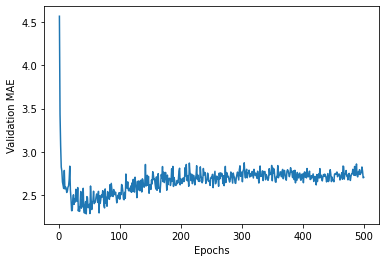

In [16]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

plot is noisy and first few points at a different scale - smooth data and omit first 10 points:  

Code to smooth data: 
replacing each data point with a weighted sum of itself and the previous smoothed point.

In [17]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points: # an empty list is 'False'
            previous = smoothed_points[-1] # the last appended point
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

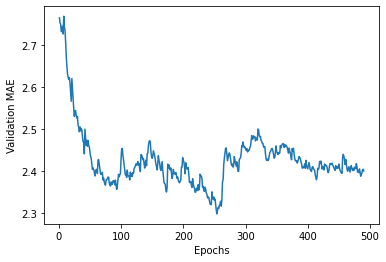

In [18]:
smooth_mae_history = smooth_curve(mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [19]:
print(np.argmin(smooth_mae_history))

253


Can see that MAE stops improving significantly after 250ish epochs - past that => **overfitting**  
    - also can see it has a bottom around 100 as well
(textbook finds that it's actually around 130)

After tuning epochs should tune size of intermediate layers  

Once done tuning: train a final production model on all the training data with best parameters then look at its performance on the test data  

In [29]:
model = build_model()
model.fit(train_data, train_targets,
epochs = 115, batch_size = 16, verbose = 0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 1ms/step - loss: 14.7429 - mae: 2.5284


In [31]:
print('$', "%2.0f" % (test_mae_score * 1000), sep='')

$2528


### Generate Predictions

In [32]:
predictions = model.predict(test_data)
predictions[0]

4/4 [==============================] - 0s 2ms/step


array([9.139447], dtype=float32)